In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import numpy as np
from torchvision import datasets, transforms, models

/home/lpetrov/projects/courses/blender/letters/.venv/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


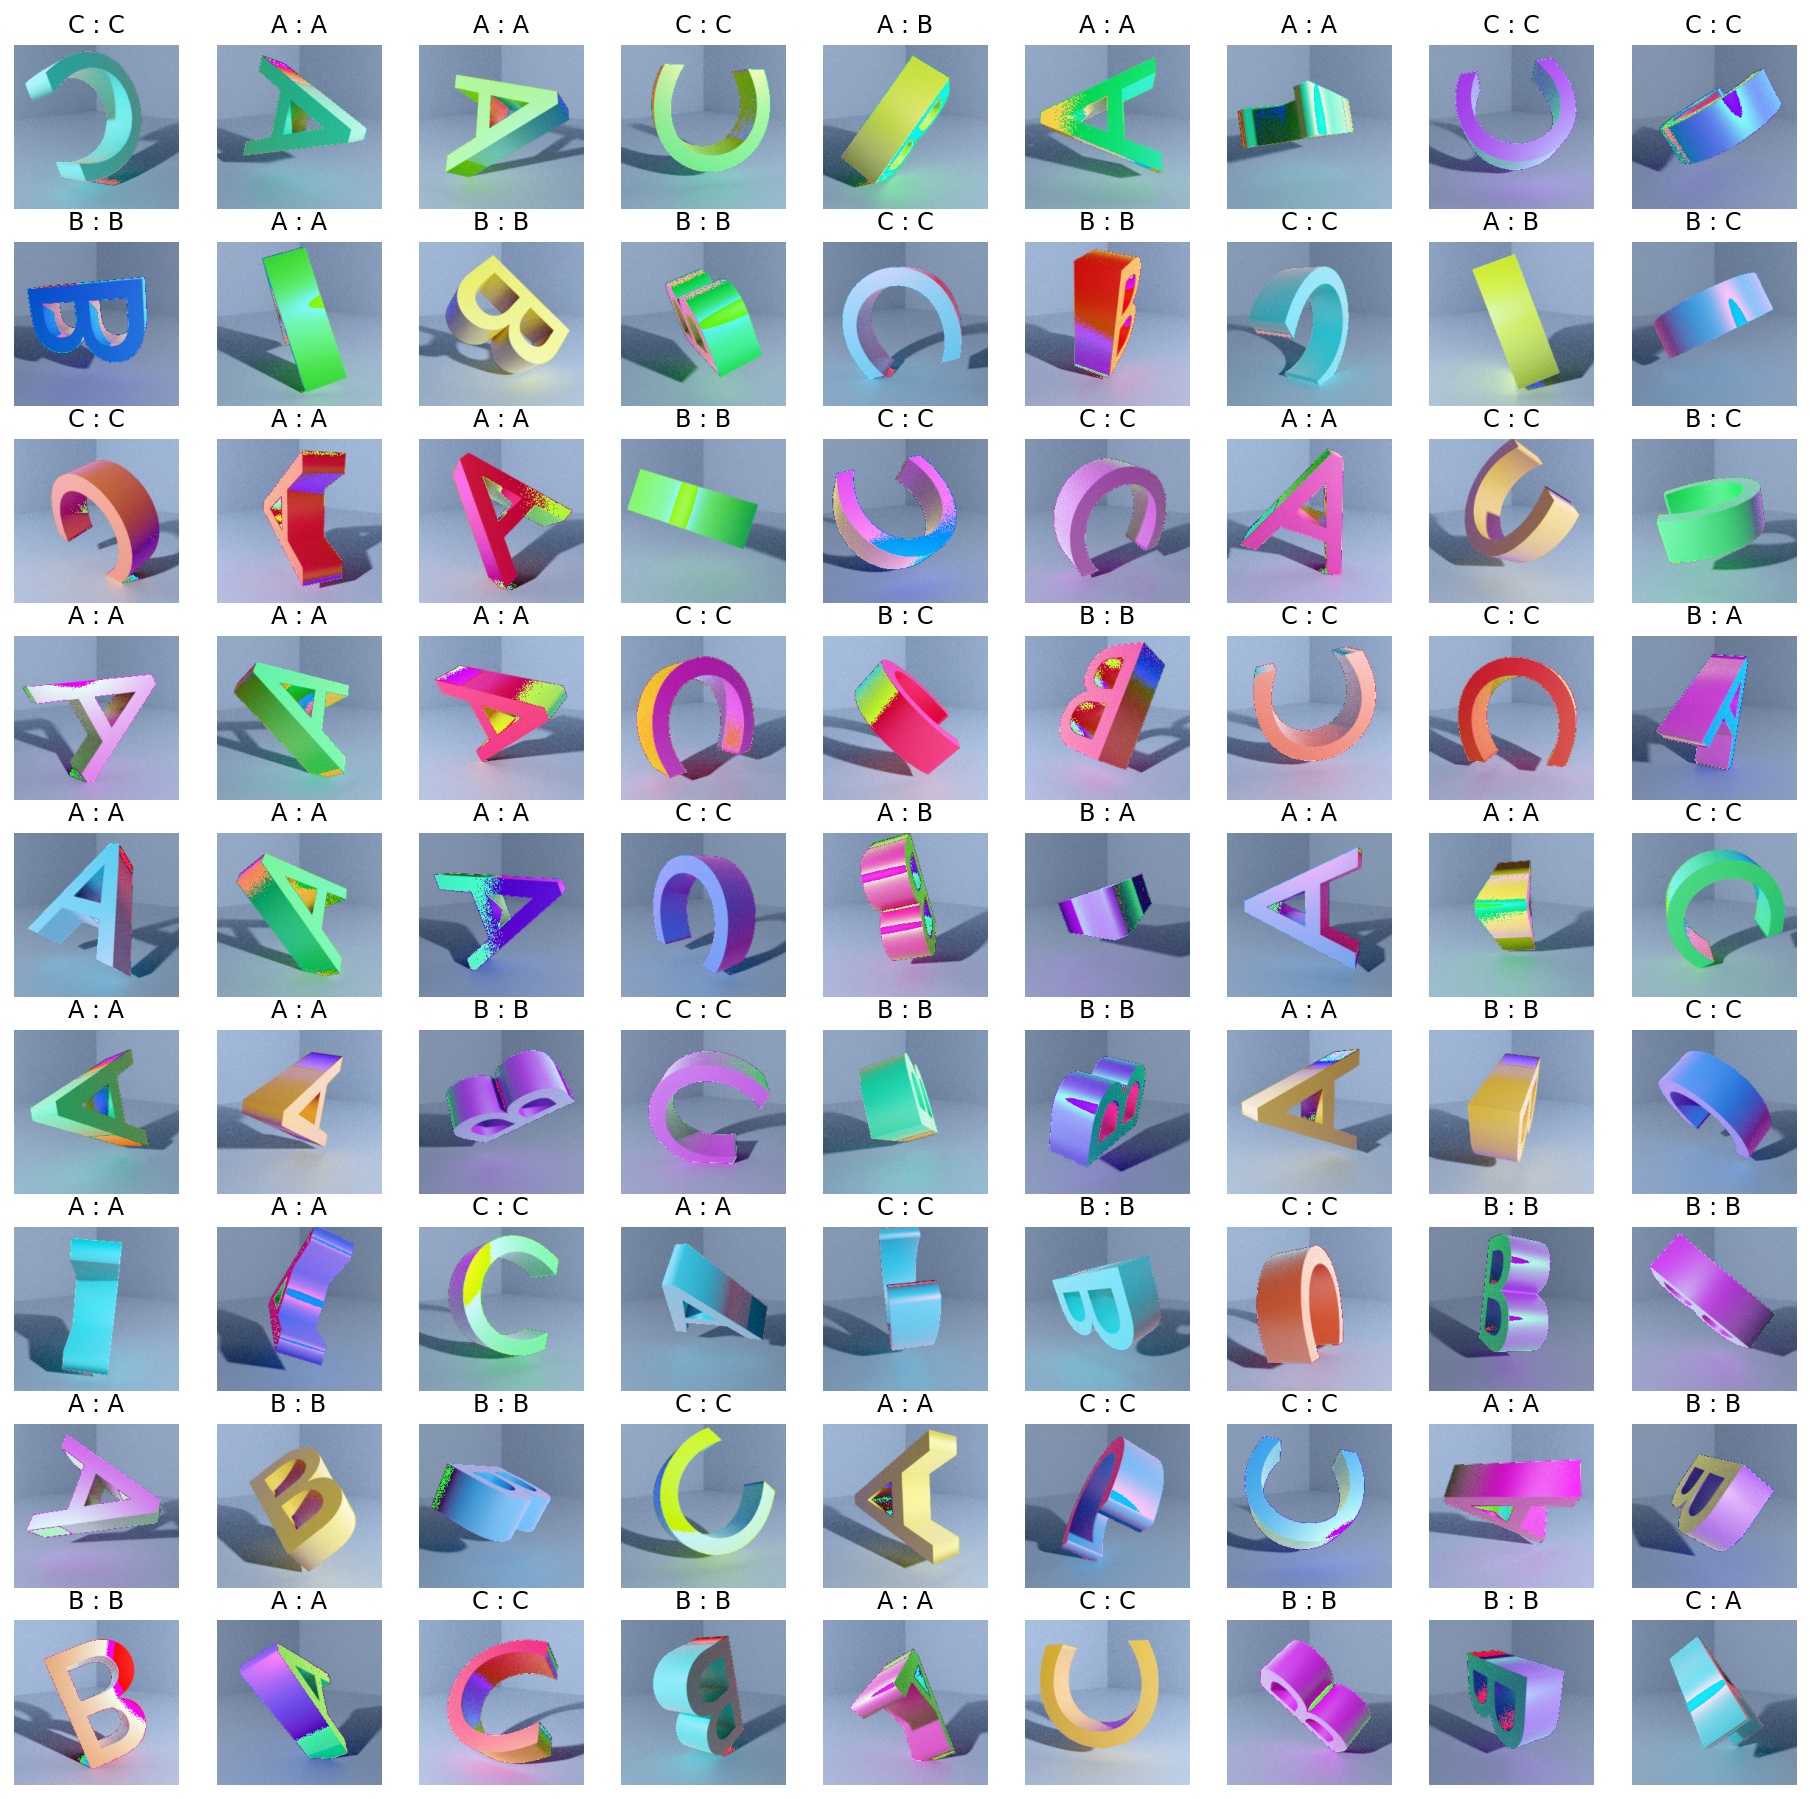

In [2]:
from networks.letters import LettersNetwork

def get_model(path='./models/letters.pth'):
    model = LettersNetwork()
    model.load_state_dict(torch.load(path))
    return model

def get_loader(batch_size=64, data_dir='./data/letters/val'):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    # TODO: Define transforms for the training data and testing data
    val_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(means, stds,),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((224,224)),
        ]
    )

    # Pass transforms in here, then run the next cell to see how the transforms look
    val_data = datasets.ImageFolder(data_dir, transform=val_transforms)
    valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    return valloader

def map_prediction(results):
    results = results.to('cpu').detach().numpy()
    results = results.squeeze()
    indx = np.where(results == np.max(results))[0][0]
    return indx

def predict(model, loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    image_tensors, labels = next(iter(loader))
    images = [x.squeeze().permute(1,2,0).numpy() for x in image_tensors]
    images = [x/x.max()*255 for x in images]
    image_tensors = image_tensors.to(device); labels = labels.to(device)
    features = model(image_tensors)
    predictions = np.array([map_prediction(x) for x in features])
    labels = labels.to('cpu').numpy()
    return predictions, labels, images

def show(predictions, labels, images, classes=['A', 'B', 'C']):

    plt.rcParams['figure.figsize'] = (16,16)
    
    side = int(np.sqrt(len(images)))
    
    for i, img in enumerate(images[0:side**2]):
        plt.subplot(side,side,i+1)    
        plt.imshow(img.astype(np.uint8))
        plt.title(f"{classes[predictions[i]]} : {classes[labels[i]]}")
        plt.axis("off")

    plt.show()
    plt.close()

model = get_model()
loader = get_loader(batch_size=81)
predictions, labels, images = predict(model, loader)
show(predictions, labels, images)